<a href="https://colab.research.google.com/github/tsakailab/spmlib/blob/master/demo/eg30_SRC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# スパース表現に基づく識別（sparse representation-based classification; SRC）

----
- [SRCによる顔認識（スライド）](https://github.com/tsakailab/prml/blob/master/lectures/SRC_tsakai.pdf)
- [早わかりスパースモデリング（テキスト）](https://drive.google.com/file/d/0Bx4bEpaTSFcgeU5LNW1rMUZMMDA)
- [SRCの原著論文](https://ieeexplore.ieee.org/abstract/document/4483511)の[PDFファイル](http://www.columbia.edu/~jw2966/papers/WYGSM09-PAMI.pdf)


目的変数として質問の顔画像が与えられたとき，それを既知の顔画像の簡潔な組合せで説明するスパース回帰分析を考えましょう．質問の顔は，組合せに選ばれた顔と同一人物ではないでしょうか．そんな仕組みの画像認識はSRCと呼ばれています．簡潔な組合せを表す非ゼロの回帰係数（スパース解）が低品質の画像からも求められるので，画質に影響され難い頑健性（robustness）がSRCの特長のひとつです．

In [1]:
#@title 顔画像データをダウンロードし，訓練画像（説明変数） `X_train` と、質問画像（目的変数） `X_q` に分けます．<p>画像：[cropped Yale face database B](https://paperswithcode.com/dataset/extended-yale-b-1)，32x32画素，2414枚，38人．</p>

import requests
import io

response = requests.get('https://github.com/tsakailab/prml/raw/master/datasets/YaleB_32x32.mat')
response.raise_for_status()
#data = np.load(io.BytesIO(response.content))
from scipy.io import loadmat
dataset = loadmat(io.BytesIO(response.content))

# split data into those for training (0.5), validation (0.5*0.5) and testing (0.5*0.5)
mybirthday = 19731115

from sklearn.model_selection import train_test_split
X_train, X_q, y_train, y_q = train_test_split(dataset['fea'], dataset['gnd'].ravel(), train_size=0.8, random_state=mybirthday)
n_train, n_q = X_train.shape[0], X_q.shape[0]
n_pixels = X_train.shape[1]
print("#train =", n_train, ", #queries =", n_q)

# zero-based indexing, shape (n,)
y_train, y_q = y_train-1, y_q-1

# scaling to [0,1]
X_train, X_q = X_train / 255., X_q / 255.

#train = 1931 , #queries = 483


### ランダムに画素を欠損させます．
- 欠損率 `missing_pixel_rate` を設定してください．
- 欠損させた画素は赤で表示されます．

In [2]:
# rate of missing pixels
missing_pixel_rate = 0.3    #### try 0.1, 0.3, 0.5 ####

Showing samples from 1931 training images, 716 pixels are available for each


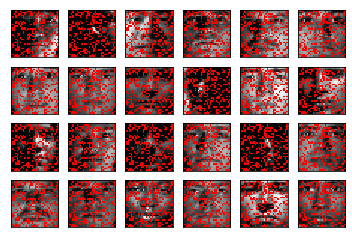

Showing samples from 483 query images each with 716 pixels are available for each


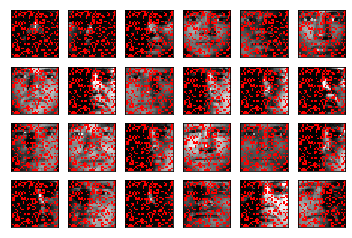

In [3]:
#@title 訓練画像（training images）と質問画像（query images）を表示します．
import numpy as np

n_pixels_miss = np.ceil(n_pixels * missing_pixel_rate).astype(int)
p_miss = np.random.choice(n_pixels, n_pixels_miss, replace=False)

# put np.nan as missing pixels
X_in_train = X_train.copy()
X_in_train[:,p_miss] = np.nan
X_in_q = X_q.copy()
X_in_q[:,p_miss] = np.nan
p_obs = ~np.isnan(X_in_q[0,:])

import matplotlib.pyplot as plt
plt.cm.gray.set_bad(color='red')

def imshows(X, subplots=(4,6)):
    vmin, vmax = 0., 1.
    if subplots[0] == 1 and subplots[1] == 1:
        plt.matshow(X.reshape(32, 32).T, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
    else:
        fig, axes = plt.subplots(subplots[0], subplots[1])
        for f, ax in zip(X, axes.ravel()):
            ax.matshow(f.reshape(32, 32).T, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
            ax.set_xticks(())
            ax.set_yticks(())

print("Showing samples from", n_train, "training images,", p_obs.sum(), "pixels are available for each")
#print("X_in_train.shape =", X_in_train.shape)
imshows(X_in_train)
plt.show()

print("Showing samples from", n_q, "query images each with", p_obs.sum(), "pixels are available for each")
#print("X_in_q.shape =", X_in_q.shape)
imshows(X_in_q)

### ★直交マッチング追跡（orthogonal matching pursuit; OMP）を実装します．

${\boldsymbol x}^\star=\arg\min_{\boldsymbol x}\|\boldsymbol x\|_0 \quad\mbox{subject to}\quad \|{\boldsymbol b}-{\boldsymbol{ Ax}}\|_2\leq \delta$

を数値計算するスパース解法のひとつです．
- [[Pati+93]](https://user.eng.umd.edu/~krishna/images/pati_reza_psk.pdf)
- 酒井の解説資料：[スライド](https://github.com/tsakailab/HDsci-SpM/blob/main/seminar/slides/Day03.pdf)，[テキスト](https://github.com/tsakailab/prml/blob/master/lectures/OMP_tsakai.pdf)
- 非ゼロ成分の計算は，残差が `delta` 以下または非ゼロが `maxnnz` 個以上になると終了します．

In [4]:
import numpy as np
from numpy import linalg

# Orthogonal matching pursuit (OMP)
def OMP(A, b, delta=1e-6, maxnnz=None):
    d, n = A.shape
    if maxnnz is None: maxnnz = d // 2
    r = b.copy()
    x = np.zeros(n)
    supp = []                                   # 台（b の説明に使う A の列の番号のリスト）
    while len(supp) < maxnnz and linalg.norm(r) > delta:
        t = np.argmax(np.abs( A.T.dot(r) ))     # 残差 r と最も類似する行列 A の列の番号 t
        supp.append(t)                          # 台 supp に t を追加する
        Asupp = A[:,supp]                       # b の説明に用いる A の列ベクトル  
        #### x[supp] = '''説明変数を Asupp，目的変数を b とする回帰係数の最小二乗解 '''
        x[supp] = linalg.lstsq(Asupp, b, rcond=None)[0]
        r = b - Asupp.dot(x[supp])              # 残差の更新
    return x

### SRCを実装します．

- [SRCの原著論文](https://ieeexplore.ieee.org/abstract/document/4483511)の[PDFファイル](http://www.columbia.edu/~jw2966/papers/WYGSM09-PAMI.pdf)：原著では$\ell_1$最小化でスパース解を得ていますが，ここではOMPを使ってみます．
- shapeが`(n, d)` の配列 `X` は，有効な画素数が `d` 個の訓練画像 `n` 枚を表します．
- `fit(X,y)` は，訓練画像 `X` を正規化した配列 `A` を作ります．`A` のshapeは `(d, n)` です．各列の訓練画像のクラス番号は，shapeが `(n,)` の配列 `y` で与えられます．
- `_predict` は，shapeが`(d,)`の質問画像 `b` に対してクラス番号を推論します．
    - スパース解 `x_sp` の非ゼロ成分数の上限 `maxnnz` と，`b` をスパース回帰したときの相対誤差の下限 `tol` を指定できます．
    - `maxnnz` を指定しない場合は，`d` の半分の値がデフォルトです．`tol` のデフォルトは0.01です．
    - 再構成画像の有効な画素値 `A.dot(x_sp)` と `b` の相対誤差が `tol` 未満，または非ゼロ成分が `maxnnz` 以上になると，OMPは終了します．
- `_compute_residual`は，各クラスの訓練画像と対応する回帰係数 `x_sp` で `b` を近似した残差（residual）を計算します．`_predict` は残差が最小のクラスを推論の結果とします．

In [5]:
from sklearn.preprocessing import normalize

class SRC:
    def __init__(self, tol=1e-2):
        self.tol = tol

    def fit(self, X, y):
        self.A = normalize(X).T             # 正規化した訓練データ X を列にもつ行列 A 
        self.y_train = y                    # 各列の訓練データのクラス番号
        self.classes_ = np.unique(y)        # クラス番号の全体集合

    def predict(self, X, tol=None, maxnnz=None):
        y_pred = [self._predict(b, tol, maxnnz)[0] for b in X]
        return np.array(y_pred)

    # 目的変数（質問画像）b のクラス番号を推論します．
    def _predict(self, b, tol=None, maxnnz=None):
        if tol is None: tol = self.tol
        x_sp = OMP(self.A, b, delta=linalg.norm(b)*tol, maxnnz=maxnnz)
        residual = self._compute_residual(x_sp, b)
        # 残差 residual が最小のクラス番号を返します．
        return self.classes_[np.argmin(residual)], residual, x_sp

    # スパース解 x_sp に基づき，各クラスの訓練データのみで
    # 目的変数（質問画像）b の合成を試みた残差 residual を返します．
    def _compute_residual(self, x_sp, b):
        residual = np.zeros(len(self.classes_))
        for i, cid in enumerate(self.classes_):
            idx = self.y_train == cid
            residual[i] = linalg.norm(b - self.A[:,idx].dot(x_sp[idx]))
        return residual

    def score(self, X, y, tol=None, maxnnz=None):
        y_pred = self.predict(X, tol, maxnnz)
        return (y == y_pred).sum() / len(y)

### SRCで欠損顔画像を認識します．
- `qid` で質問画像の番号を指定します．`b` は質問画像の有効な画素値のみを持つ配列です．
- 左に質問画像，右に再構成画像が表示されます．欠損なしの訓練画像と回帰係数（スパース解）`x_sp` で再構成しているので，欠損を修復した質問画像が得られます．
- 更に，回帰係数 `x_sp` と各クラスの残差 `residual` をプロットします．

Query ID: 9 ( 0, .., 483 )
Ground truth: 15 , Predicted: 15
Left: query, Right: sparse reconstruction


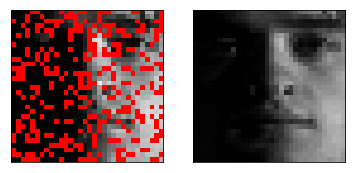

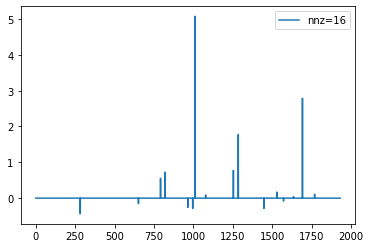

<BarContainer object of 38 artists>

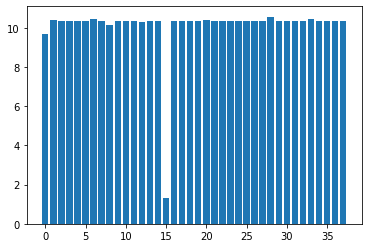

In [6]:
model = SRC()
model.fit(X_in_train[:,p_obs], y=y_train)

qid = 9     # try 0, .., n_q
print("Query ID:", qid, "( 0, ..,", n_q, ")")
b = X_in_q[qid, p_obs]
y_pred, residual, x_sp = model._predict(b, tol=1e-1, maxnnz=40)

print("Ground truth:", y_q[qid], ", Predicted:", y_pred)
print("Left: query, Right: sparse reconstruction")
imshows(np.c_[X_in_q[qid,:], normalize(X_train).T.dot(x_sp)].T, subplots=(1,2)); plt.show()

plt.plot(x_sp, label="nnz="+str(np.count_nonzero(x_sp))); plt.legend(); plt.show()
plt.bar(model.classes_, residual)

### すべての質問画像をSRCで認識します．
- 数十秒～数分の時間がかかるので注意してください．
- `tol` や `maxnnz` を変えて結果を観察してください．

In [7]:
model = SRC()
model.fit(X_in_train[:,p_obs], y=y_train)

maxnnz = 40  # try 5, 10, 20, 30, 40, 50, 60
tol = 0.1   # try 0.01, etc.
from time import time

print("Predicting labels (val) ..", end="")

t0 = time()
y_pred = model.predict(X_q[:,p_obs], maxnnz=maxnnz, tol=tol)

print('.. done in %.2fs.' % (time() - t0))

matches = (y_pred == y_q)
print("Accuracy = %d / %d = %2.1f%%" % (matches.sum(), len(matches), 100*matches.sum()/float(len(matches))))

Predicting labels (val) .... done in 37.30s.
Accuracy = 470 / 483 = 97.3%


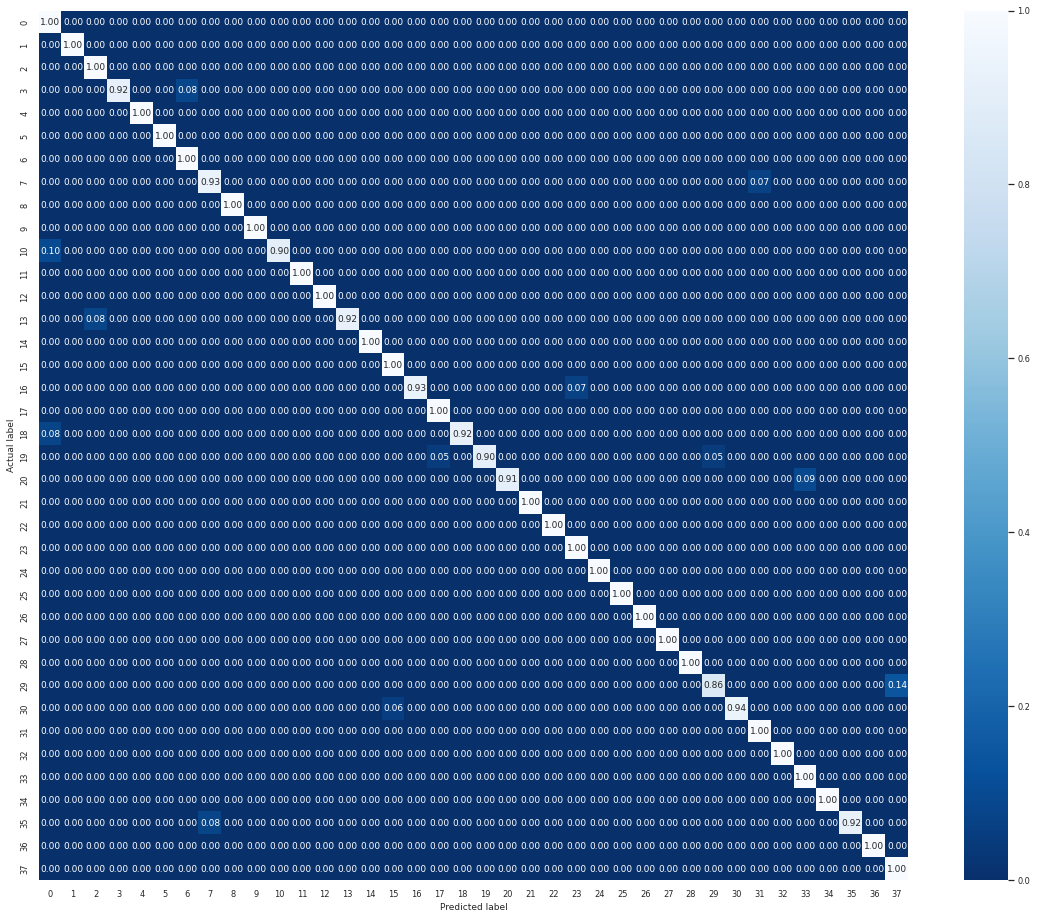

In [8]:
#@title 混同行列を表示します．
from sklearn import metrics
import seaborn as sns

# Make predictions on test data
cm = metrics.confusion_matrix(y_q, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20,16))
sns.set(font_scale=0.75)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", linewidths=0, square=True, cmap='Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

----
お疲れさまでした．